---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Applied Machine Learning Assignment 5
### Reddit  moderators  spend significanttime removingthe  commentsthat  are  offensive, provocative or disruptsany quality discussions. 
### In this assignment, you willtrain a model that takes the commenttextas an input and predicts if it should be kept or removed. 
### Dataset can be found at followinglink. https://www.kaggle.com/areeves87/rscience-popular-comment-removal 
### For this assignment, only use the reddit_200k training and test set, and only use the “body” and “removed” columns.
### Be careful about the encoding when loading the data.Pick an appropriate evaluation metric for imbalanced binary classification.
---------------------------------------------------------------------------------------------------------------------------------------------------------------

# 1.) Create a baseline model using a bag-of-words approach and a linear model.

## a.) Load data

In [1]:
import pandas as pd

data = pd.read_csv("./rscience-popular-comment-removal/reddit_200k_train.csv", encoding = "ISO-8859-1")

In [2]:
data.head()

Unnamed: 0                                               body  score.x  \
0           1  I've always been taught it emerged from the ea...        2   
1           2  As an ECE, my first feeling as "HEY THAT'S NOT...        2   
2           3  Monday: Drug companies stock dives on good new...        5   
3           4  i learned that all hybrids are unfertile i won...        0   
4           5  Well i was wanting to get wasted tonight.  Not...        3   

  parent_id.x       id  created_utc.x  retrieved_on  REMOVED  
0   t3_81u15i  dv551g6     1520121101    1524782256    False  
1   t3_72sk35  dnl66g6     1506533157    1507150439     True  
2   t3_8o88yr  e02sjhz     1528087570    1532170350     True  
3   t3_6xg9t8  dmfojjp     1504290041    1506407514    False  
4   t3_99wi9m  e4rtew8     1535140675    1537893540    False

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data["body"], data["REMOVED"], test_size=0.22, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [4]:
X_train.head()

146301    What about the 60 or so days per year when I'd...
73848     MIT is as legit as it comes, but I have an inc...
54833     This looks really exciting, but I must admit t...
75354     I like the fact that I'm starting to see some ...
34041     The diet is primarily based around breads and ...
Name: body, dtype: object

In [5]:
y_train.head()

146301    False
73848      True
54833     False
75354     False
34041     False
Name: REMOVED, dtype: bool

## b.) Create bag of words model

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
X_train_vect = CountVectorizer()
X_train_bow = X_train_vect.fit_transform(X_train)

# ----------------------------------------
# Uncomment for counts and features.
# ----------------------------------------
# print(X_train_vect.get_feature_names())
len(X_train_vect.get_feature_names())

84520

## c.) Apply linear regression to bag of words

In [7]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
clf = LogisticRegression(max_iter=3000).fit(X_train_bow, y_train)

In [8]:
clf.score(X_train_bow, y_train)

0.8201195869556345

## d.) Visualize the coefficients

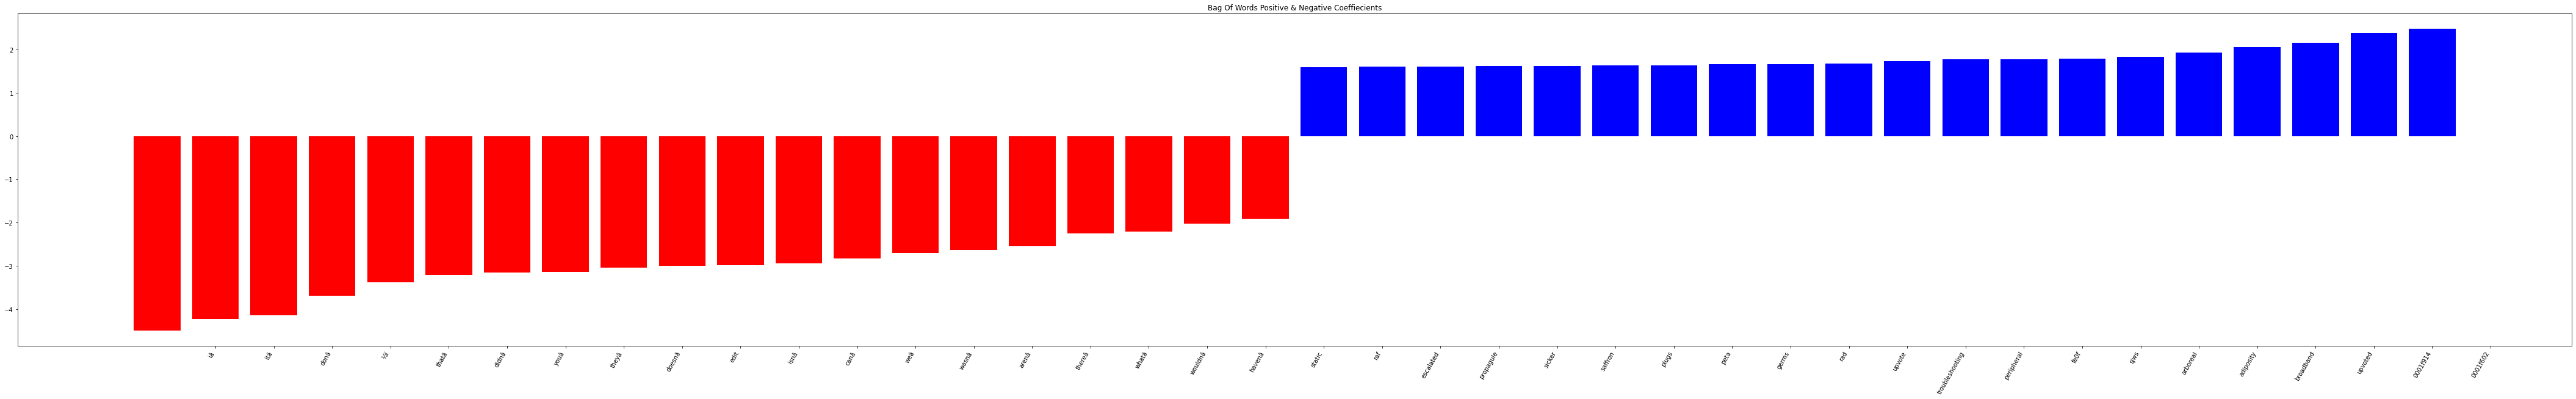

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(75, 10))
    plt.rcParams['figure.dpi'] = 300
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.title("Bag Of Words Positive & Negative Coeffiecients")
    plt.show()

plot_coefficients(clf, X_train_vect.get_feature_names())

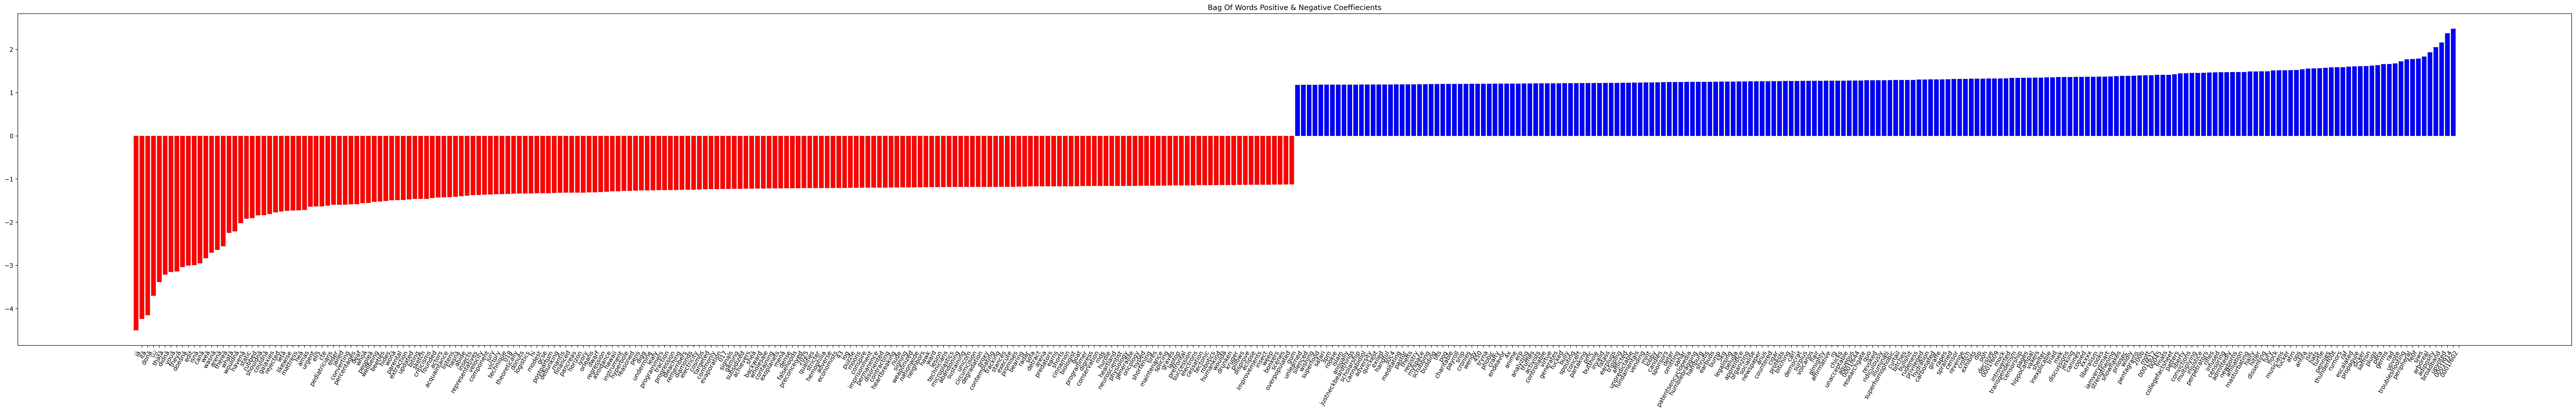

In [11]:
plot_coefficients(clf, X_train_vect.get_feature_names(), 200)

# 2.) Try using n-grams, characters, tf-idf rescaling and possibly other ways to tune the BoW model. Be aware that you might need to adjust the (regularization of the) linear model for different feature sets.

## a.) Lematization, not asked for, however thought would be a good call to reduce features. Not a fan of seeing a bunch of the same word. 

In [12]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

import nltk
nltk.download('punkt')
nltk.download('wordnet')

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

[nltk_data] Downloading package punkt to /home/sampiecz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sampiecz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## b.) N-grams & TFIDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string 

def preprocessing(line):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    return line

X_train_tfidf_vectorizer = TfidfVectorizer(
    preprocessor=preprocessing,
    ngram_range=(1, 3),
    stop_words='english',
    tokenizer=LemmaTokenizer(),
)

X_train_tfidf = X_train_tfidf_vectorizer.fit_transform(X_train)

/home/sampiecz/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [14]:
len(X_train_tfidf_vectorizer.get_feature_names())

3003180

## c.) Apply linear regression to the TFIDF results - This was the best result I got

In [15]:
clf = LogisticRegression(max_iter=3000).fit(X_train_tfidf, y_train)
clf.score(X_train_tfidf, y_train)

0.8816885025101017

/home/sampiecz/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sampiecz/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sampiecz/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 157 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sampiecz/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sampiecz/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sampiecz/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWar

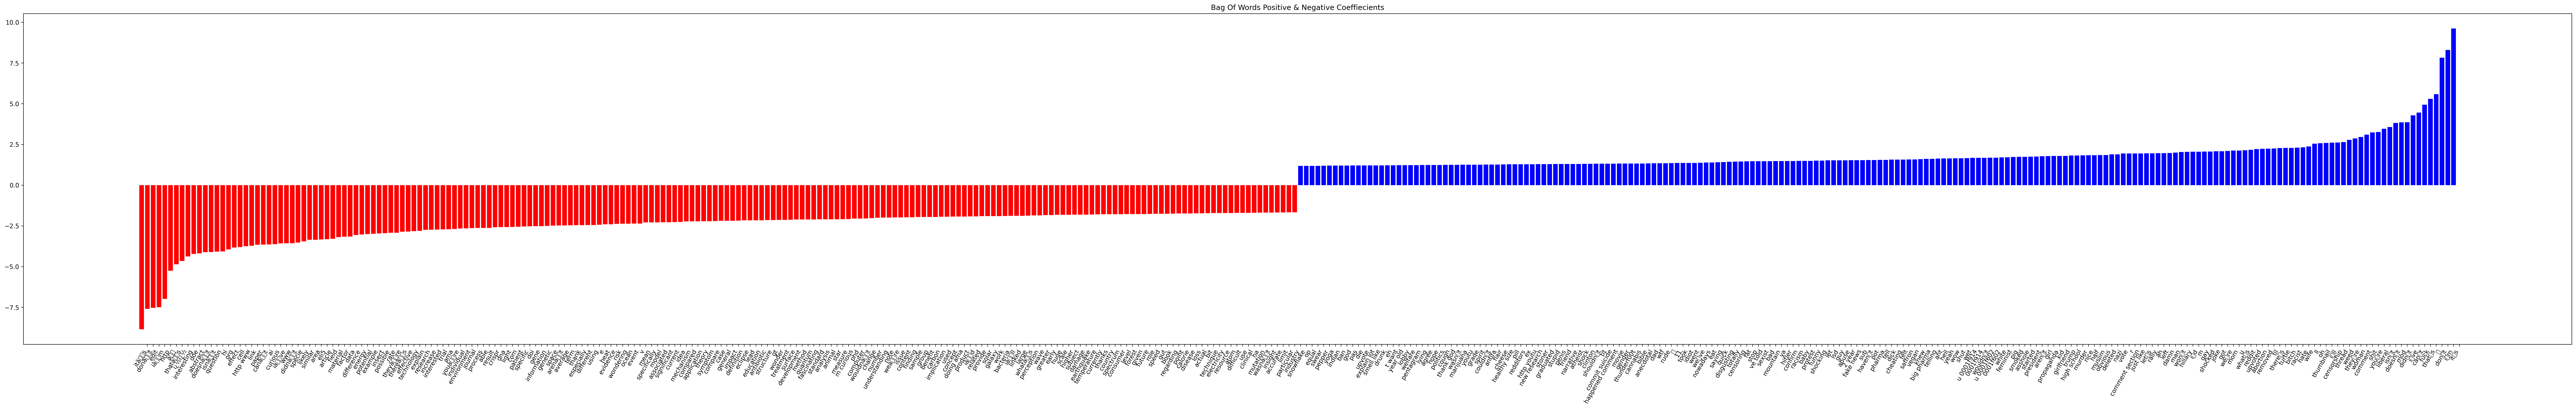

In [16]:
plot_coefficients(clf, X_train_tfidf_vectorizer.get_feature_names(), 200)

# 3.) Explore  other  features  you  can  derive  from  the  text,  such  as  html,  length, punctuation,  capitalization  or  other  features  you  deem  important  from  exploring  the dataset.

## a.) Added token pattern and increased min_df

In [17]:
X_train_tfidf_vectorizer = TfidfVectorizer(
    min_df=8,
    token_pattern=r"\b\w\w+\b",
    preprocessor=preprocessing,
    ngram_range=(1, 3),
    stop_words='english',
    tokenizer=LemmaTokenizer(),
)

X_val_tfidf_vectorizer = TfidfVectorizer(
    min_df=8,
    token_pattern=r"\b\w\w+\b",
    preprocessor=preprocessing,
    ngram_range=(1, 3),
    stop_words='english',
    tokenizer=LemmaTokenizer(),
)

X_train_tfidf = X_train_tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = X_val_tfidf_vectorizer.fit_transform(X_val)

/home/sampiecz/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/home/sampiecz/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [18]:
clf = LogisticRegression(max_iter=3000).fit(X_train_tfidf, y_train)
print("LR Score: ", clf.score(X_train_tfidf, y_train))

LR Score:  0.7803865148361291


/home/sampiecz/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sampiecz/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sampiecz/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 157 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sampiecz/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sampiecz/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/sampiecz/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWar

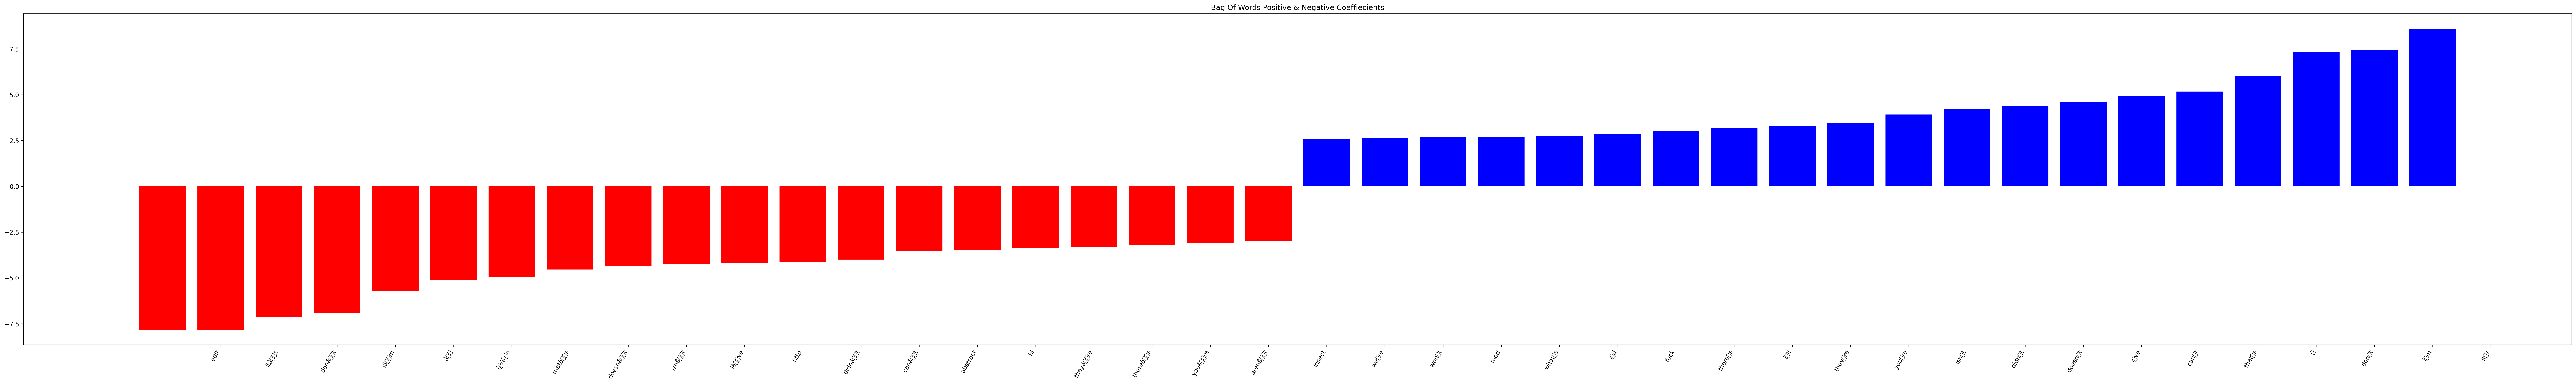

In [19]:
plot_coefficients(clf, X_train_tfidf_vectorizer.get_feature_names())

## b.) Remove bad values / gibberish / commas somehow, was not able to figure this out in time. I didn't want to just find and replace each character manually but I could've gone through and manually done the top ones. 

In [44]:
# THis looked promising but didn't get to try it out -  https://stackoverflow.com/questions/57340142/user-warning-your-stop-words-may-be-inconsistent-with-your-preprocessing

## c.) Clusters out of curiousity

In [20]:
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE

def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=True)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=True)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset,)
    ax[0].set_title("PCA")
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title("TSNE")


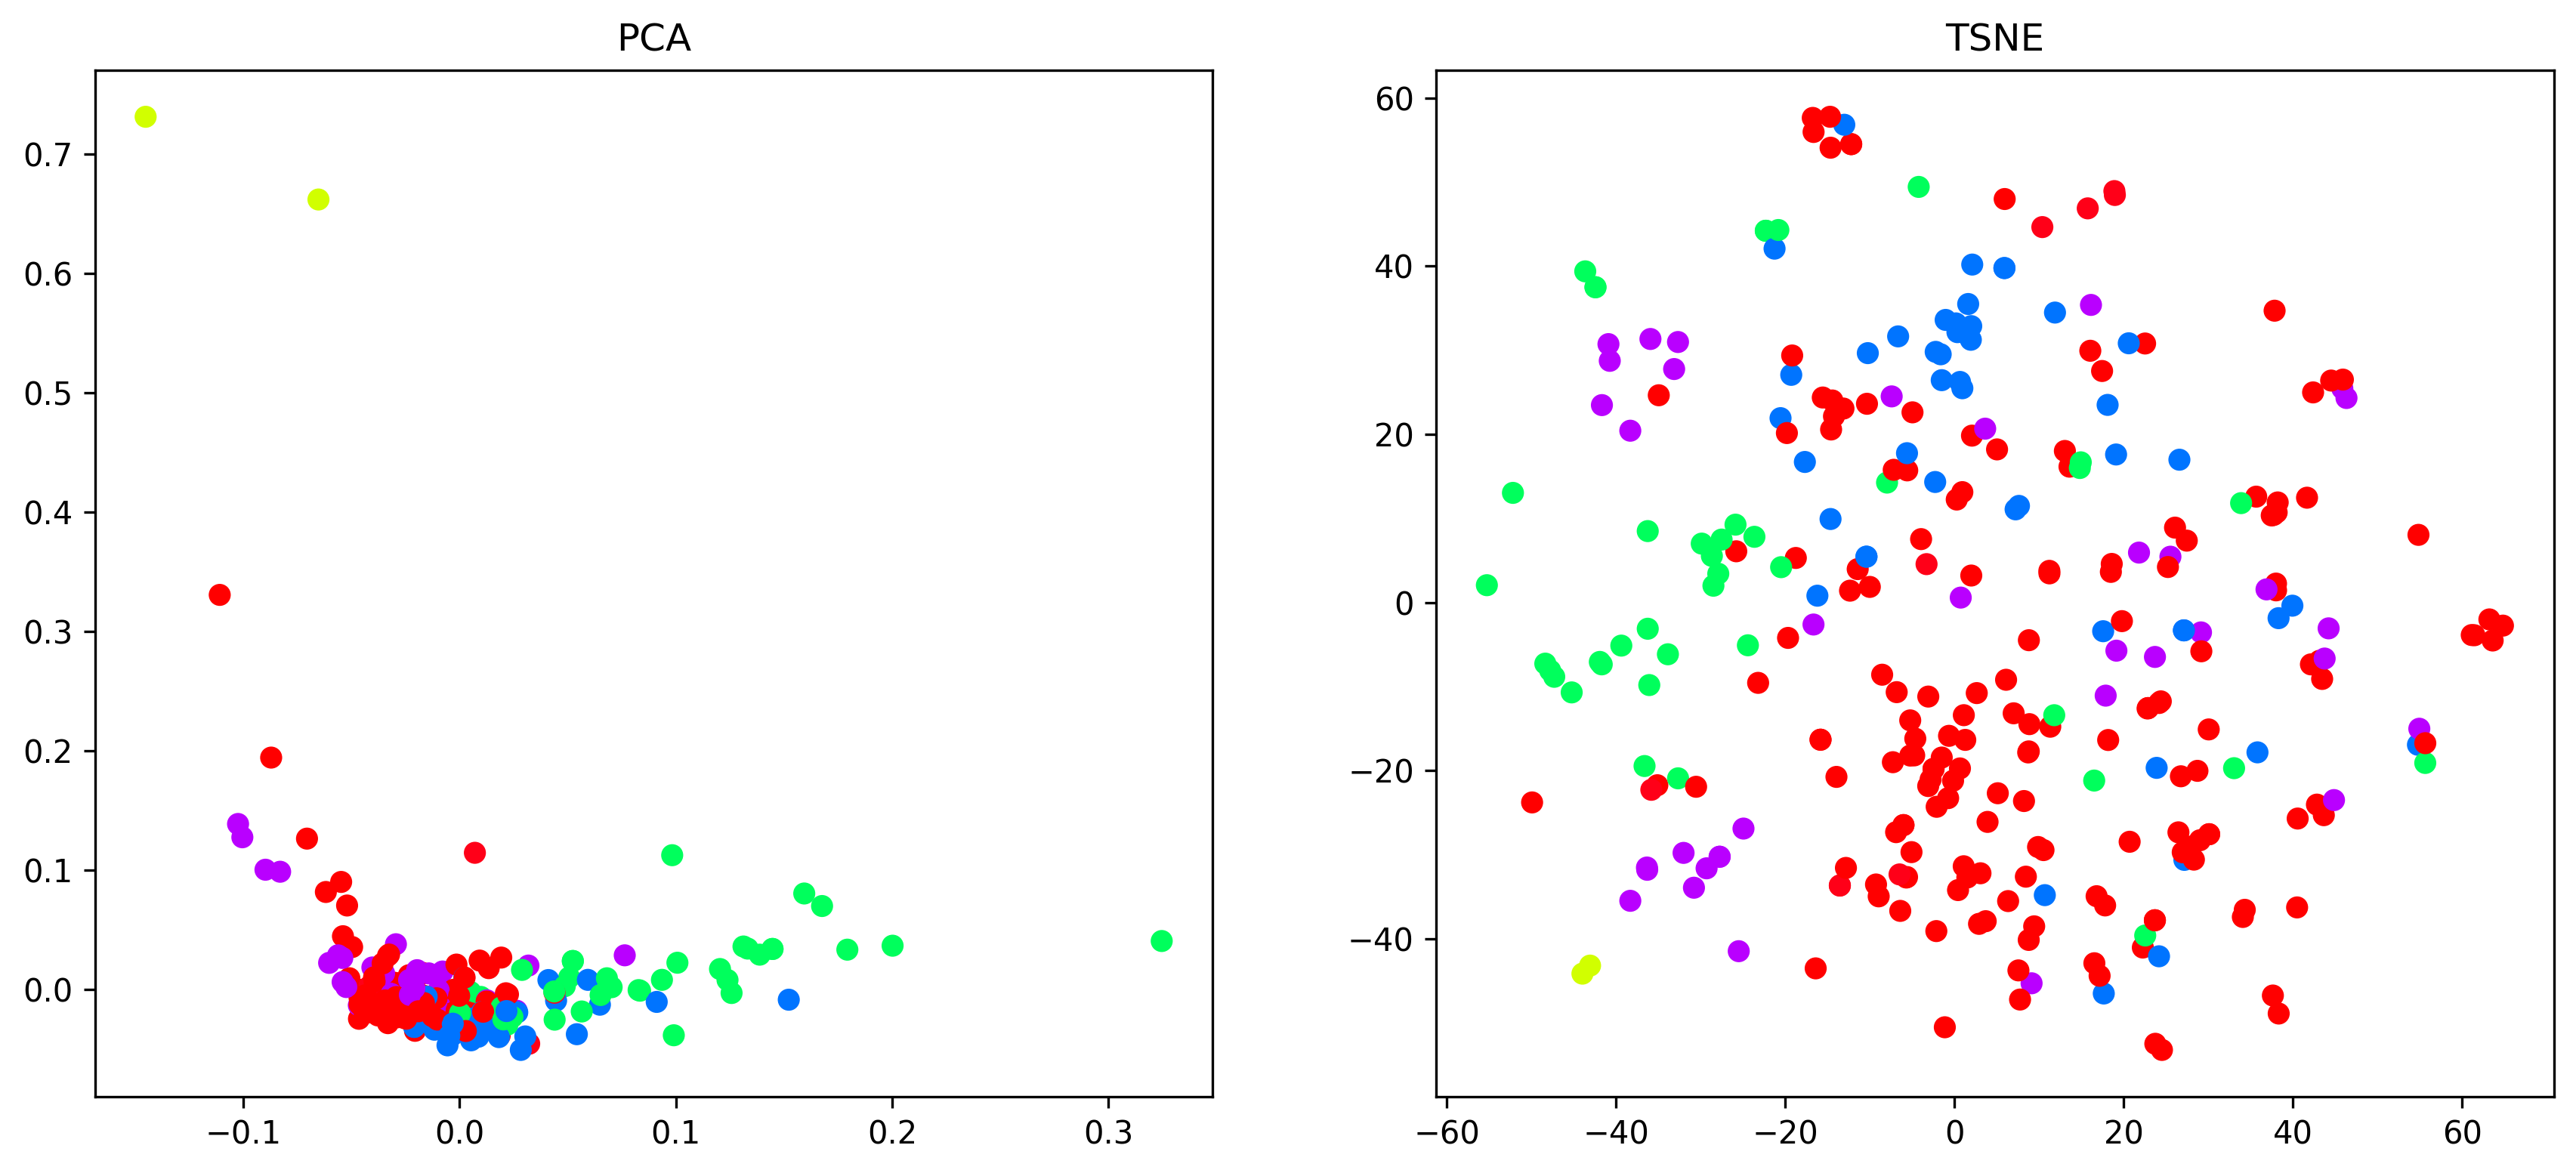

In [21]:
clusters = MiniBatchKMeans(n_clusters=6, init_size=1024, batch_size=2048, random_state=20).fit_predict(X_train_tfidf)
plot_tsne_pca(X_train_tfidf, clusters)

In [22]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    print("-------------------------------------------------")
    print("Top Keywords For Each Cluster For Each File")
    print("-------------------------------------------------")

    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

get_top_keywords(X_train_tfidf, clusters, X_train_tfidf_vectorizer.get_feature_names(), 10)       

-------------------------------------------------
Top Keywords For Each Cluster For Each File
-------------------------------------------------

Cluster 0
s,ha,u,time,science,m,study,make,doe,like

Cluster 1
www,com,reddit,www reddit com,www reddit,reddit com,comment removed,message,comment,removed

Cluster 2
know,like,doesn,doesn t,isn t,isn,don t,don,s,t

Cluster 3
know,time,thing,make,t,think,s,like,just,people

Cluster 4
org,ha,http www,study,www,article,com,year,http,wa

Cluster 5
bad,like,people,t,good news,s good,s,thing,good thing,good


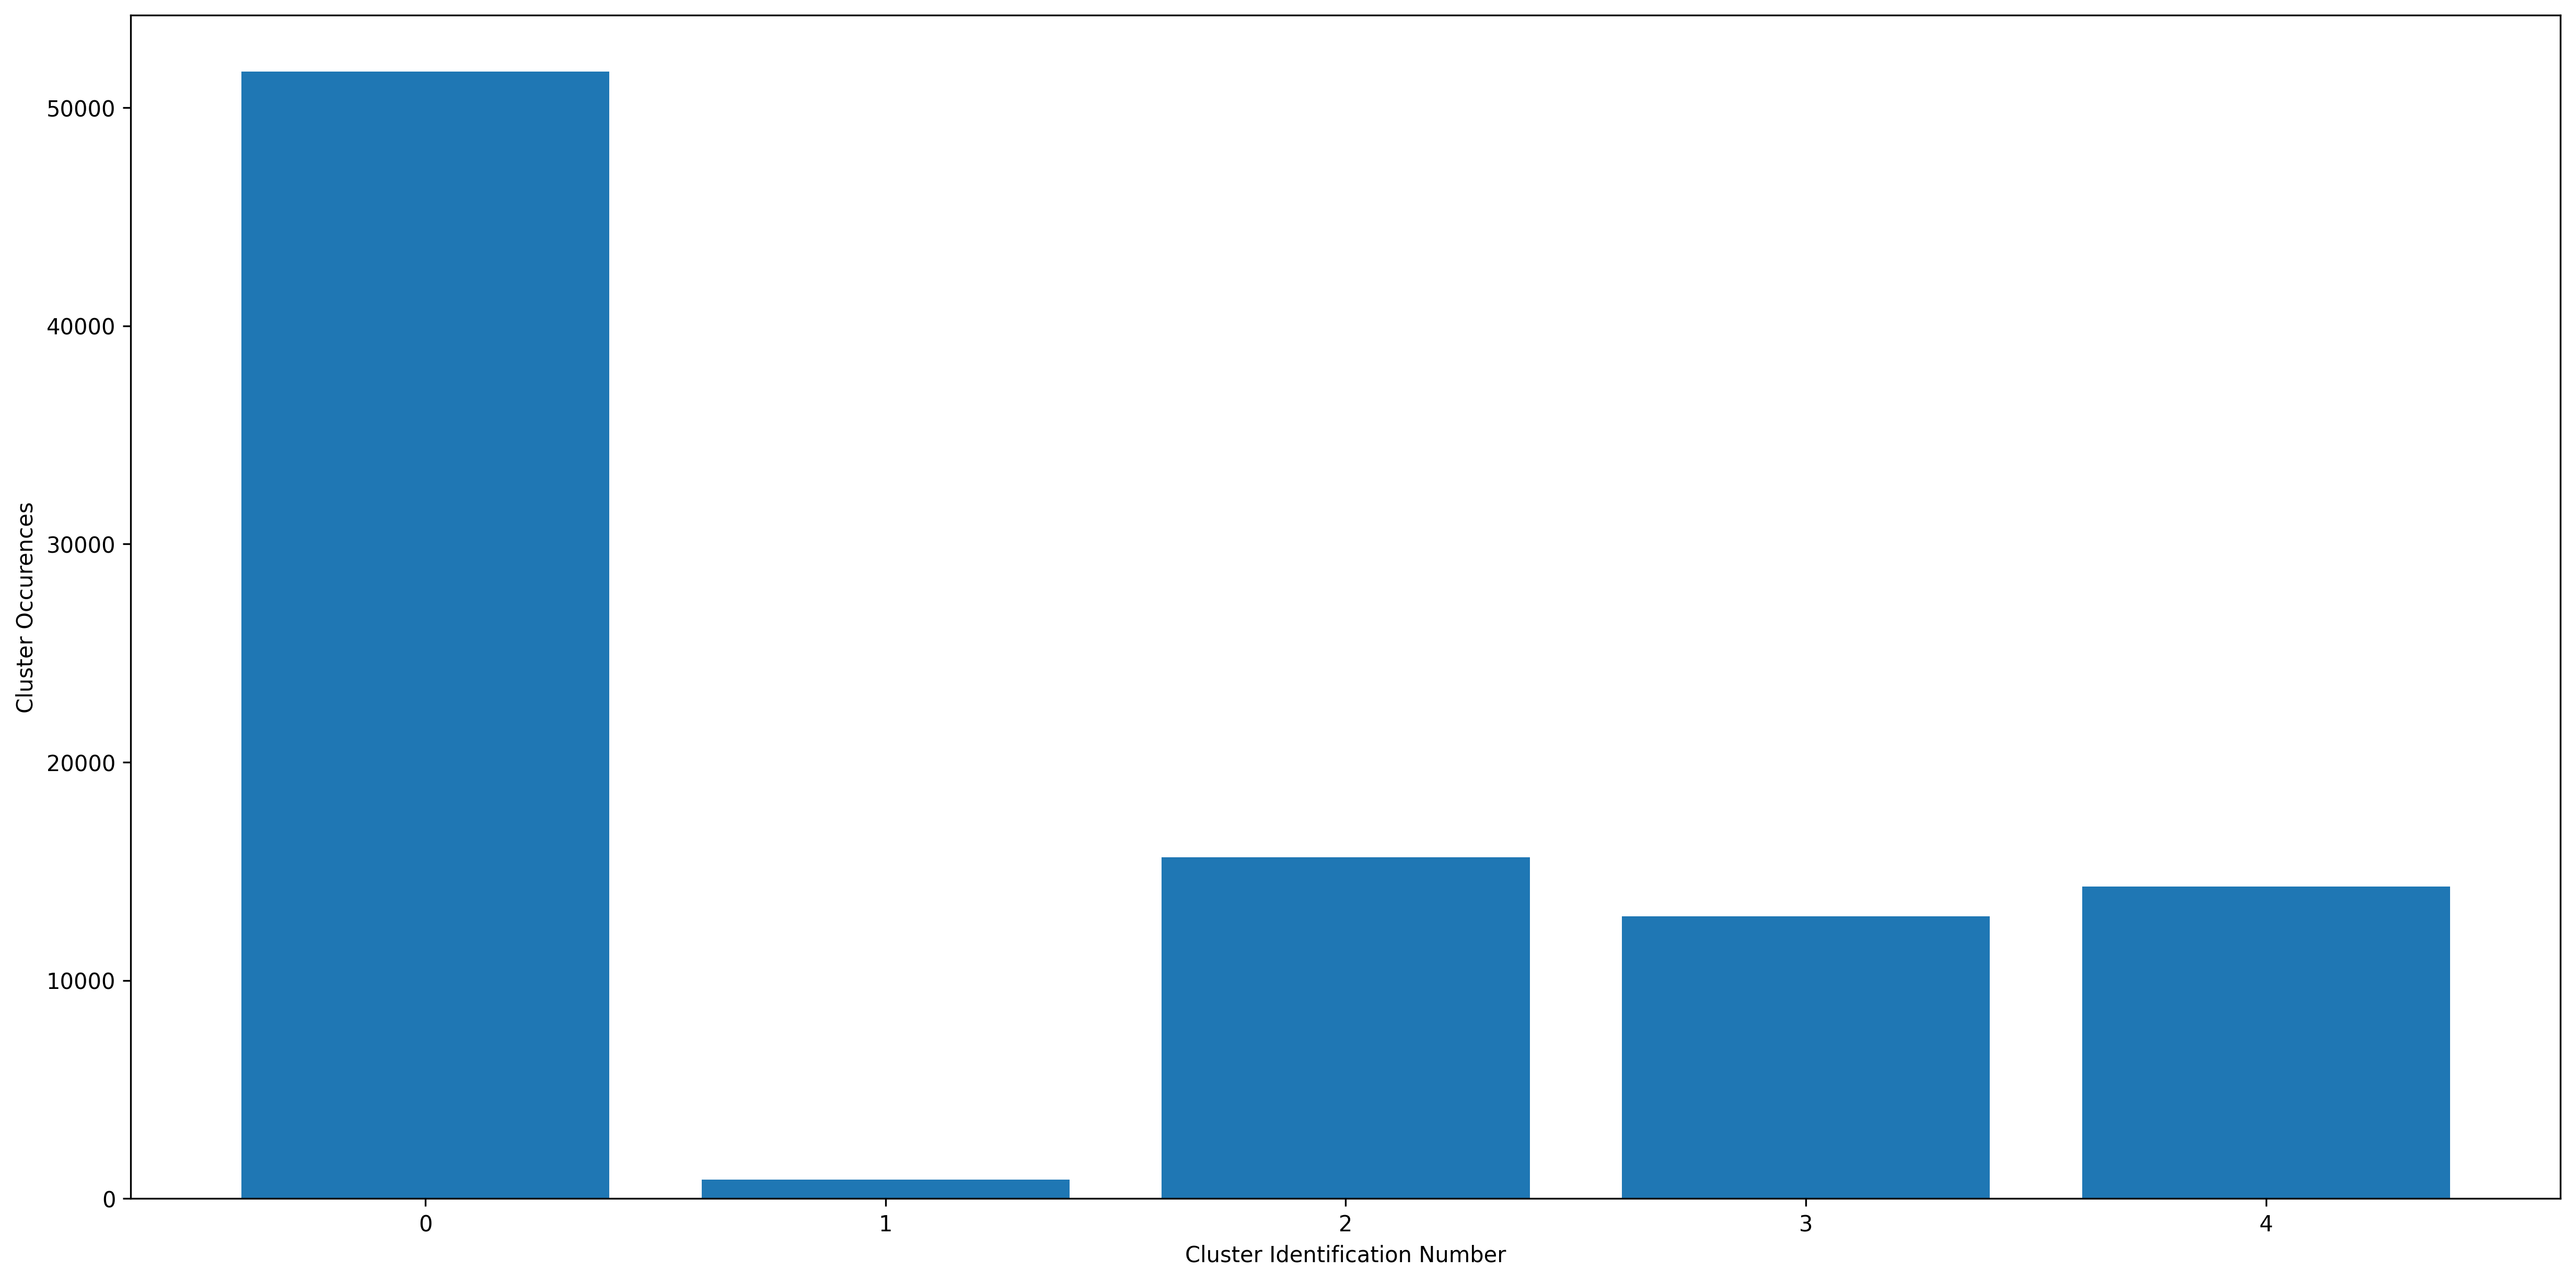

In [23]:
plt.show()
clustersList = [item for item in clusters]
counts = []

for item in range(0,5):
    counts.append(clustersList.count(item))

plt.figure(figsize=(20,10))    
plt.xlabel("Cluster Identification Number")
plt.ylabel("Cluster Occurences")
plt.bar(range(0,5), counts)
plt.show()

## LSA- LSA with Truncated SVD is better than PCA

In [24]:
import matplotlib.cm as cm
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import TruncatedSVD

def plot_lsa(data, labels):
    
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=100000, replace=True)

    scaler = MaxAbsScaler()
    X_train_scaled = scaler.fit_transform(X_train_tfidf)
    X_val_scaled = scaler.fit_transform(X_val_tfidf)
    lsa_scaled = TruncatedSVD(n_components=100)
    X_train_lsa_scaled = lsa_scaled.fit_transform(X_train_scaled)
    X_val_lsa_scaled = lsa_scaled.fit_transform(X_val_scaled)
    idx = np.random.choice(range(X_train_lsa_scaled.shape[0]), size=300, replace=True)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(figsize=(10, 5))
    
    ax.scatter(X_train_lsa_scaled[idx, 0], X_train_lsa_scaled[idx, 1], c=label_subset,)
    ax.set_title("LSA")
    plt.show()
    plt.title("Explained Variance Ratio")
    #plt.xtitle("Component Index")
    plt.semilogy(lsa_scaled.explained_variance_ratio_)
    plt.show()
    
    
    plt.scatter(X_train_lsa_scaled[:, 1], X_train_lsa_scaled[:, 3], alpha=.1, c=y_train)
    lr_lsa = LogisticRegressionCV(max_iter=3000).fit(X_train_lsa_scaled[:, :10], y_train)
    lr_lsa.score(X_val_lsa_scaled[:, :10], y_val)
    lr_lsa.score(X_train_lsa_scaled[:, :10], y_train)

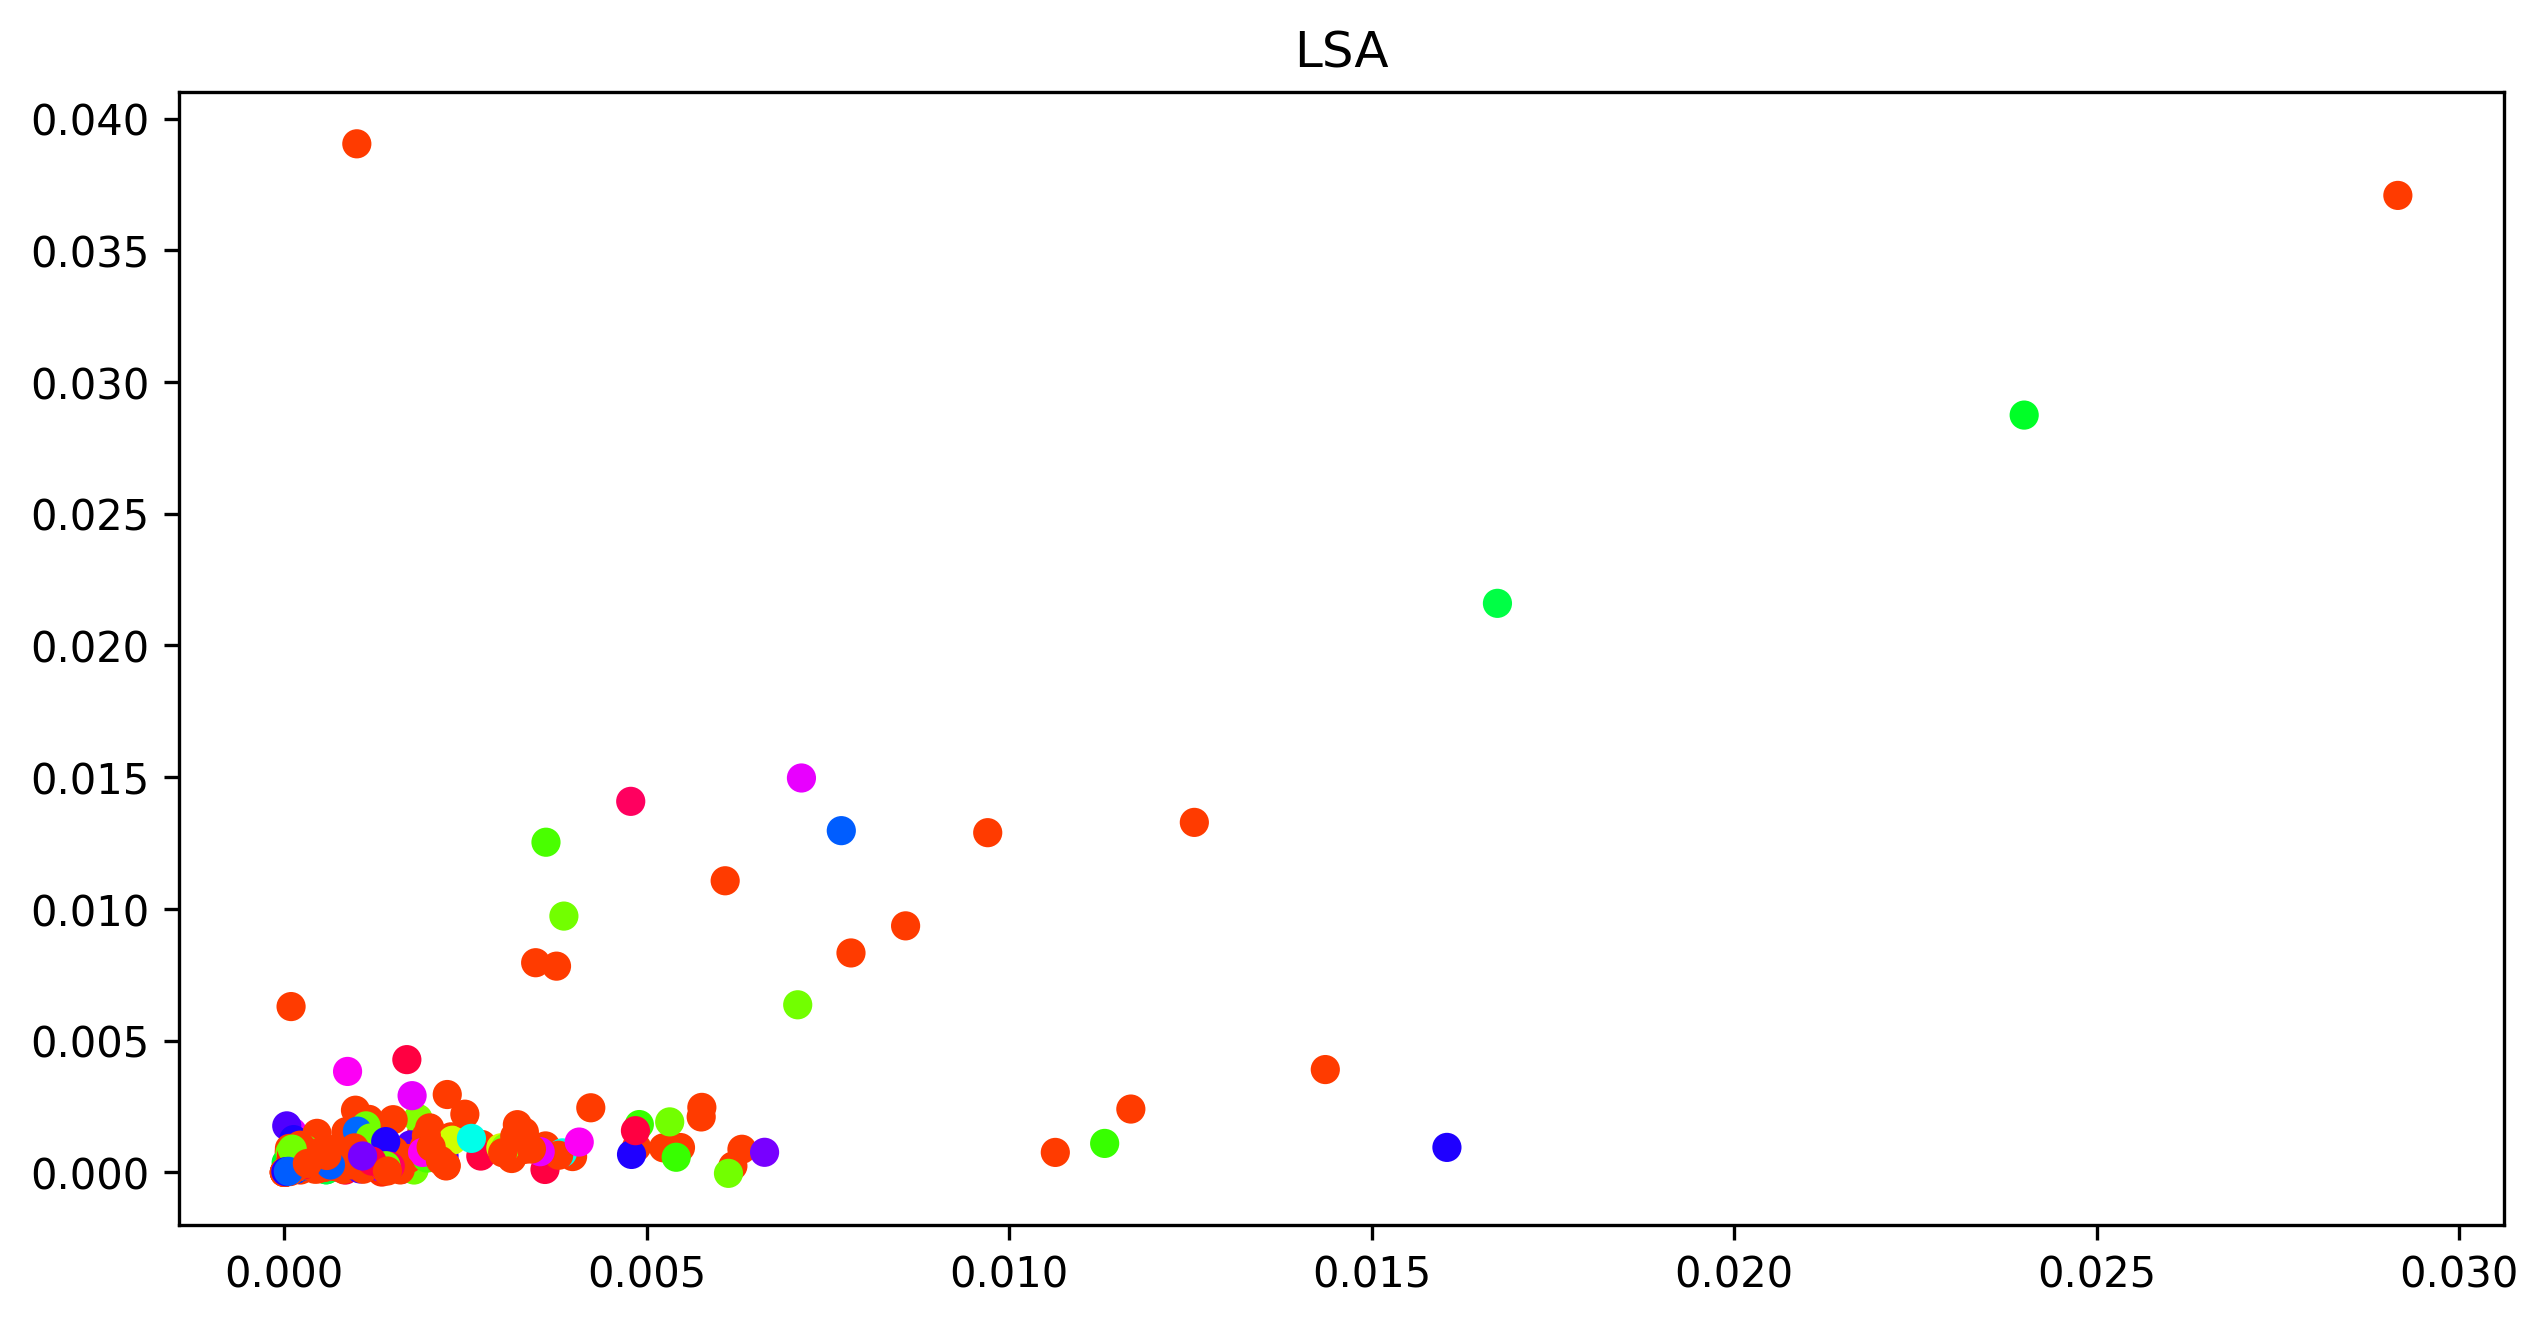

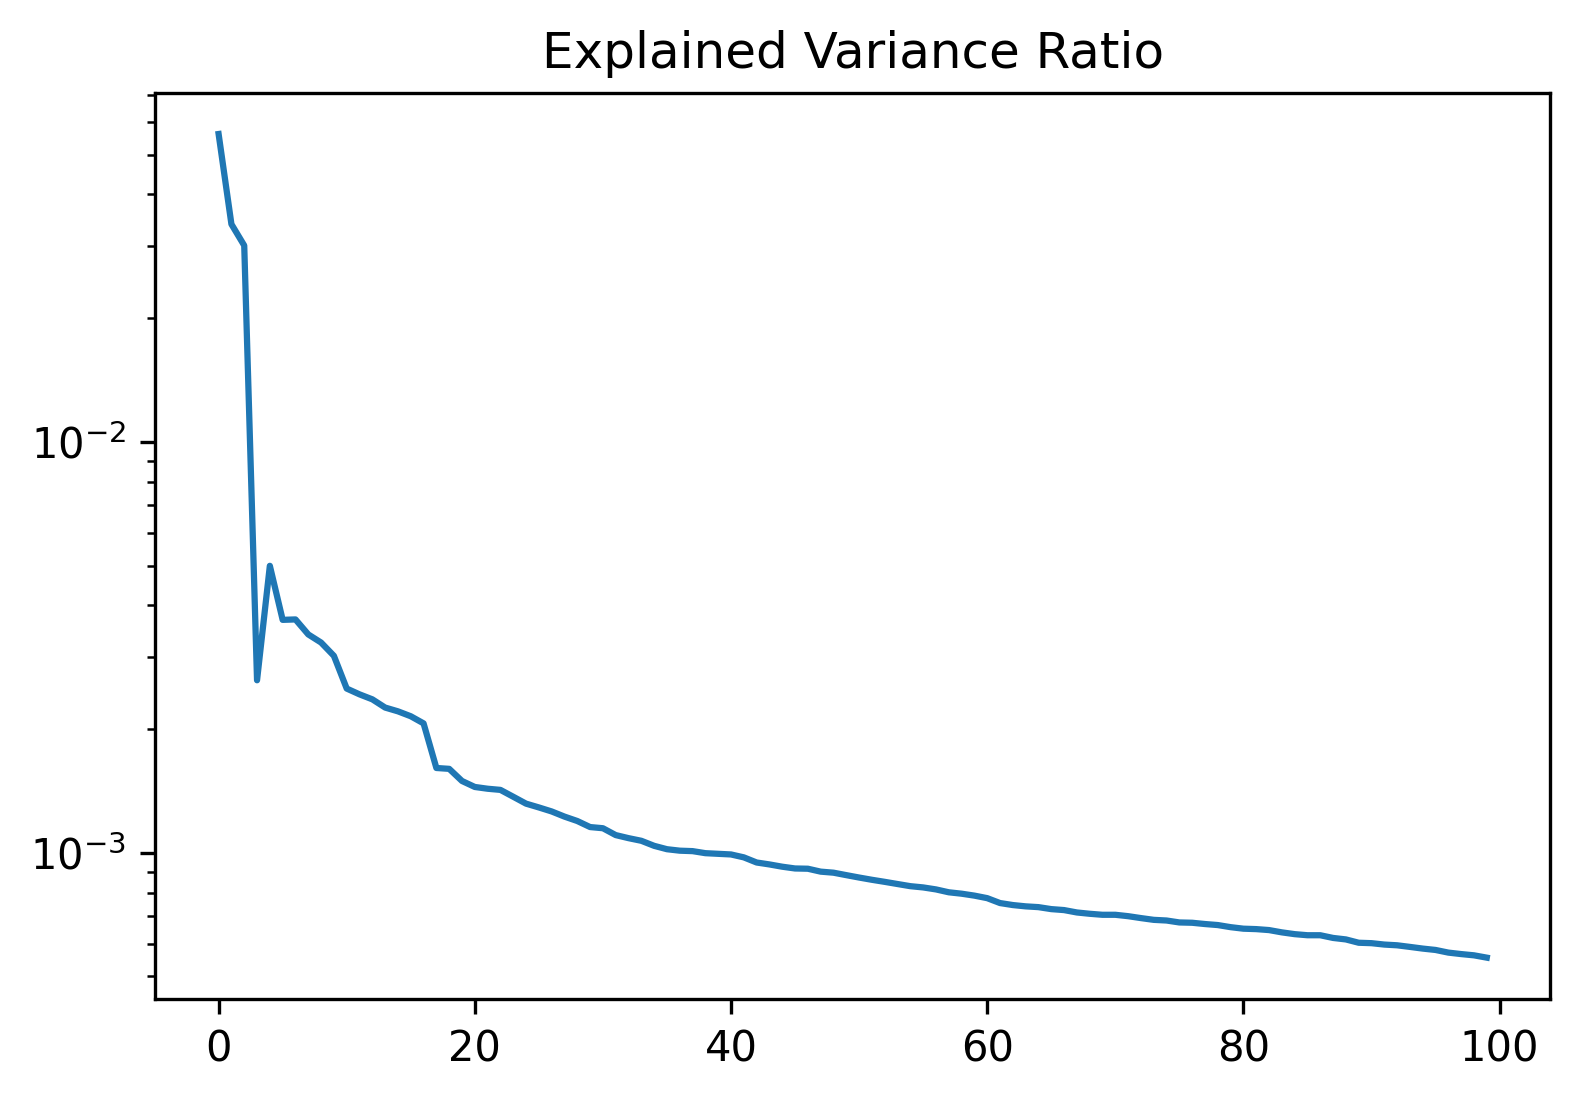

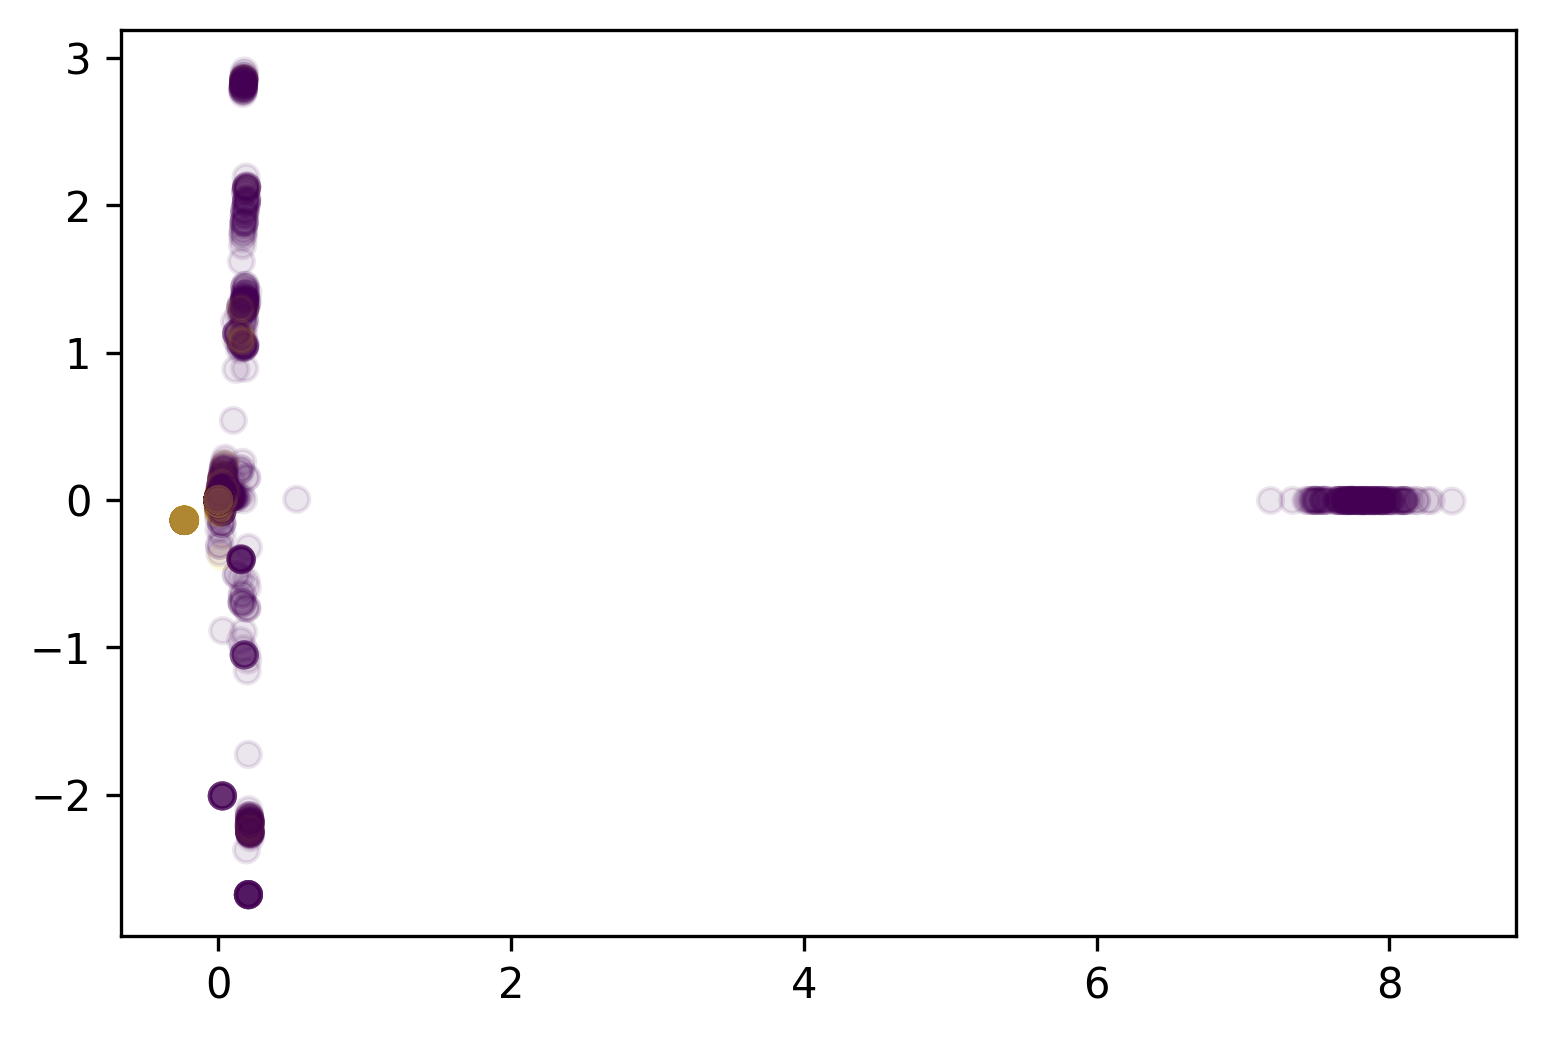

In [25]:
clusters = MiniBatchKMeans(n_clusters=100, init_size=1000, batch_size=1000, random_state=20).fit_predict(X_train_tfidf)
plot_lsa(X_train_tfidf, clusters)

In [26]:
get_top_keywords(X_train_tfidf, clusters, X_train_tfidf_vectorizer.get_feature_names(), 10)       

-------------------------------------------------
Top Keywords For Each Cluster For Each File
-------------------------------------------------

Cluster 0
great,remember,couple,tool,believed,haha,ape,remember wa,used tool,great ape

Cluster 1
protective,higher risk,conclusion study,study provides,protective effect,analytic,child adolescent,evidence showing,risk injury,adhd

Cluster 2
removed,large,home,recently,safe,bee,s better,large number,transferred,porch

Cluster 3
thing,t just,like,isn t just,people,just,s,t,isn,isn t

Cluster 4
thing,think,need,make,time,study,just,like,wa,people

Cluster 5
m,people,just,right wing,wing,left,s,wa,wa right,right

Cluster 6
little,depression,happy,pick,relief,immunity,passive,s little,greedy,damnit

Cluster 7
aren t going,just,like,people aren t,people aren,s,people,t,aren t,aren

Cluster 8
generates,generate,t,isn,isn t,correlation,play,variable,observation,hidden

Cluster 9
thing like,cold,magic,thing,candy,work like,popping,thing work,like cand

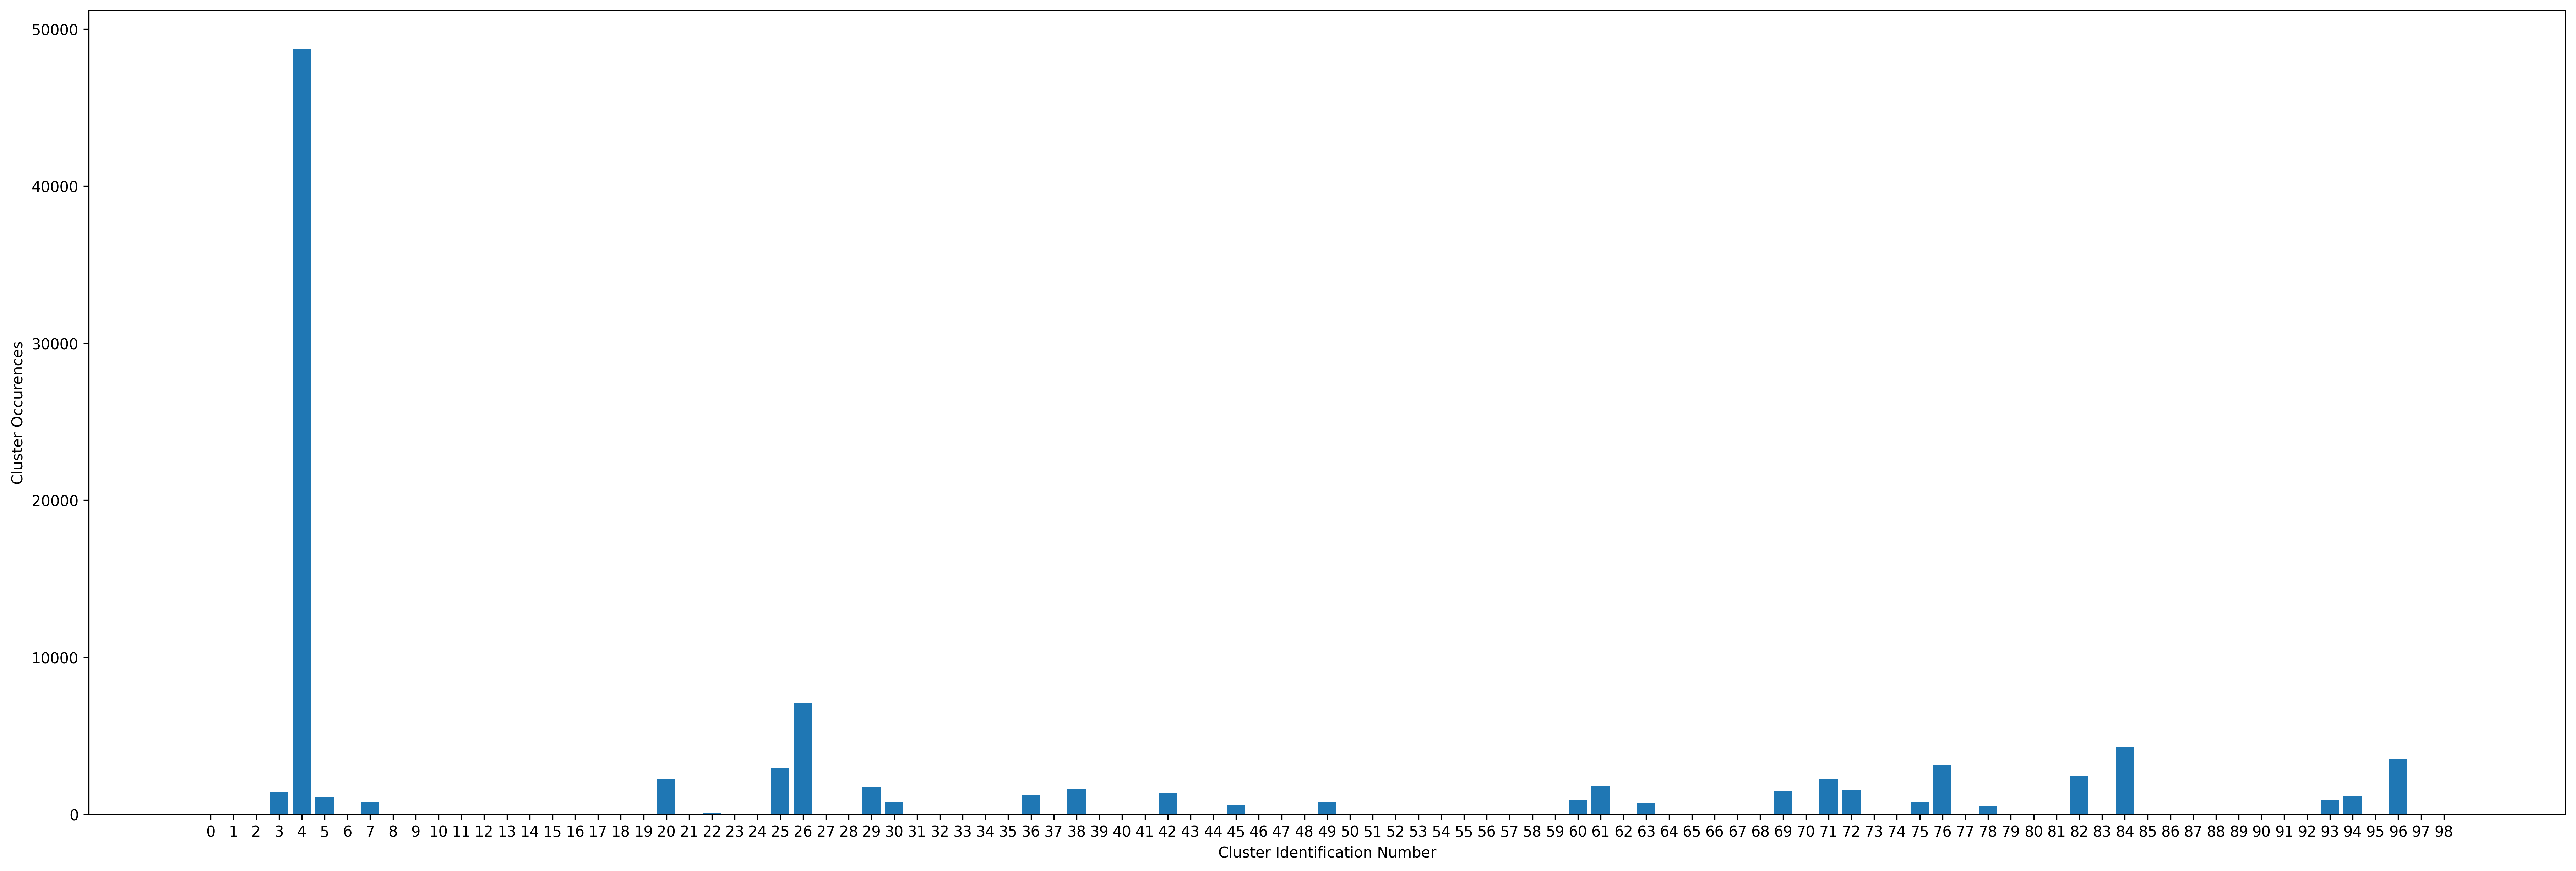

In [27]:
plt.show()
clustersList = [item for item in clusters]
counts = []

for item in range(0,99):
    counts.append(clustersList.count(item))
fig, ax = plt.subplots(figsize=(30,10))
plt.xlabel("Cluster Identification Number")
plt.ylabel("Cluster Occurences")
ax.set_xticks(range(0,99))
plt.bar(range(0,99), counts)
plt.show()

# 4.) Use a pretrained word-embedding (word2vec, glove or fasttext) instead of the bag-of-words model. Does this improve classification?

## a.) This model was not as good, I probably didn't tune it properly. 

In [29]:
import spacy
#activated = spacy.prefer_gpu()

print("1")
nlp = spacy.load("en_core_web_lg", disable=['tagger', 'parser', 'ner'])
print("2")
X_train_spacy = [nlp(itemBody).vector for itemBody in X_train]
print("3")
X_train_vstacked = np.vstack(X_train_spacy)
print("4")

1
2
3
4


In [30]:
clf = LogisticRegression(max_iter=3000).fit(X_train_vstacked, y_train)
clf.score(X_train_vstacked, y_train)

0.6814415738133137

In [31]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(max_iter=3000).fit(X_train_vstacked, y_train)
clf.score(X_train_vstacked, y_train)

0.6815129994694095

## b.) Showing similiar word

In [32]:
queries = [w for w in nlp.vocab if w.is_lower and w.prob >= -15]

def most_similar(word, count=10):
    by_similarity = sorted(queries, key=lambda w: word.similarity(w), reverse=True)
    return [w.orth_ for w in by_similarity[:count]]

most_similar(nlp("removed"))

/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__mai

['removed',
 'remove',
 'removing',
 'cleaned',
 'removal',
 'placed',
 'replaced',
 'permanently',
 'stripped',
 'immediately']

## c.) Used gensim

In [34]:
import gensim

def read_corpus(text, tokens_only=False):
    for i, line in enumerate(text):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(
                gensim.utils.simple_preprocess(line), [i])
train_corpus = list(read_corpus(X_train))
val_corpus = list(read_corpus(X_val, tokens_only=True))
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=55)

In [35]:
model.wv.most_similar("removed")

[('deleted', 0.7627586126327515),
 ('censored', 0.6734635829925537),
 ('submission', 0.608801543712616),
 ('checked', 0.5537724494934082),
 ('banned', 0.5537415146827698),
 ('prescribing', 0.5450892448425293),
 ('sketchy', 0.5431708693504333),
 ('top', 0.5407817363739014),
 ('prescribed', 0.5382544994354248),
 ('senescent', 0.537481427192688)]

## d.) Sentiment analysis

In [1]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
res = [nlp(t.decode()) for t in X_train]

/home/sampiecz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sampiecz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sampiecz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sampiecz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

RuntimeError: At least one of TensorFlow 2.0 or PyTorch should be installed. To install TensorFlow 2.0, read the instructions at https://www.tensorflow.org/install/ To install PyTorch, read the instructions at https://pytorch.org/.

## e.) Bert for feature extraction

In [3]:
nlp = pipeline("feature-extraction")
bert = [nlp(t.decode()) for t in X_train]

RuntimeError: At least one of TensorFlow 2.0 or PyTorch should be installed. To install TensorFlow 2.0, read the instructions at https://www.tensorflow.org/install/ To install PyTorch, read the instructions at https://pytorch.org/.